# Principle Component Analysis 

Goal: 

- Describe what PCA is to a friend 
- Understand the "math" behind PCA (eigenvectors and eigenvalues)
- Learn something knew about machine learning

## Agenda

1. Everything we need to know about PCA

2. What is it that we are trying to solve.

3. Exploring the data 

4. Applying PCA 

5. Small intro to machine learning 

6. Train and test our ML model. 

7. Q&A time :) 

In [1]:
# IMPORTS 

from IPython.display import Image
import time
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(suppress=True)
from pandasql import sqldf
import matplotlib.pyplot as plt
import copy
import plotly.express as px
%matplotlib inline

## 1. Everything we need to know about PCA

### What is PCA?

Principle Component Analysis, PCA, is a dimensionality-reduction method. PCA takes in 4 or more dimensions, and is able to reduce them to 2 dimensions. A dimension that we are able to plot and observe. This plot will show us similar instances clustered together. PCA will also show us which independent variables (features), are the most valuable when clustering the data. 

Let us use the following example to better illustrate what I mean.  

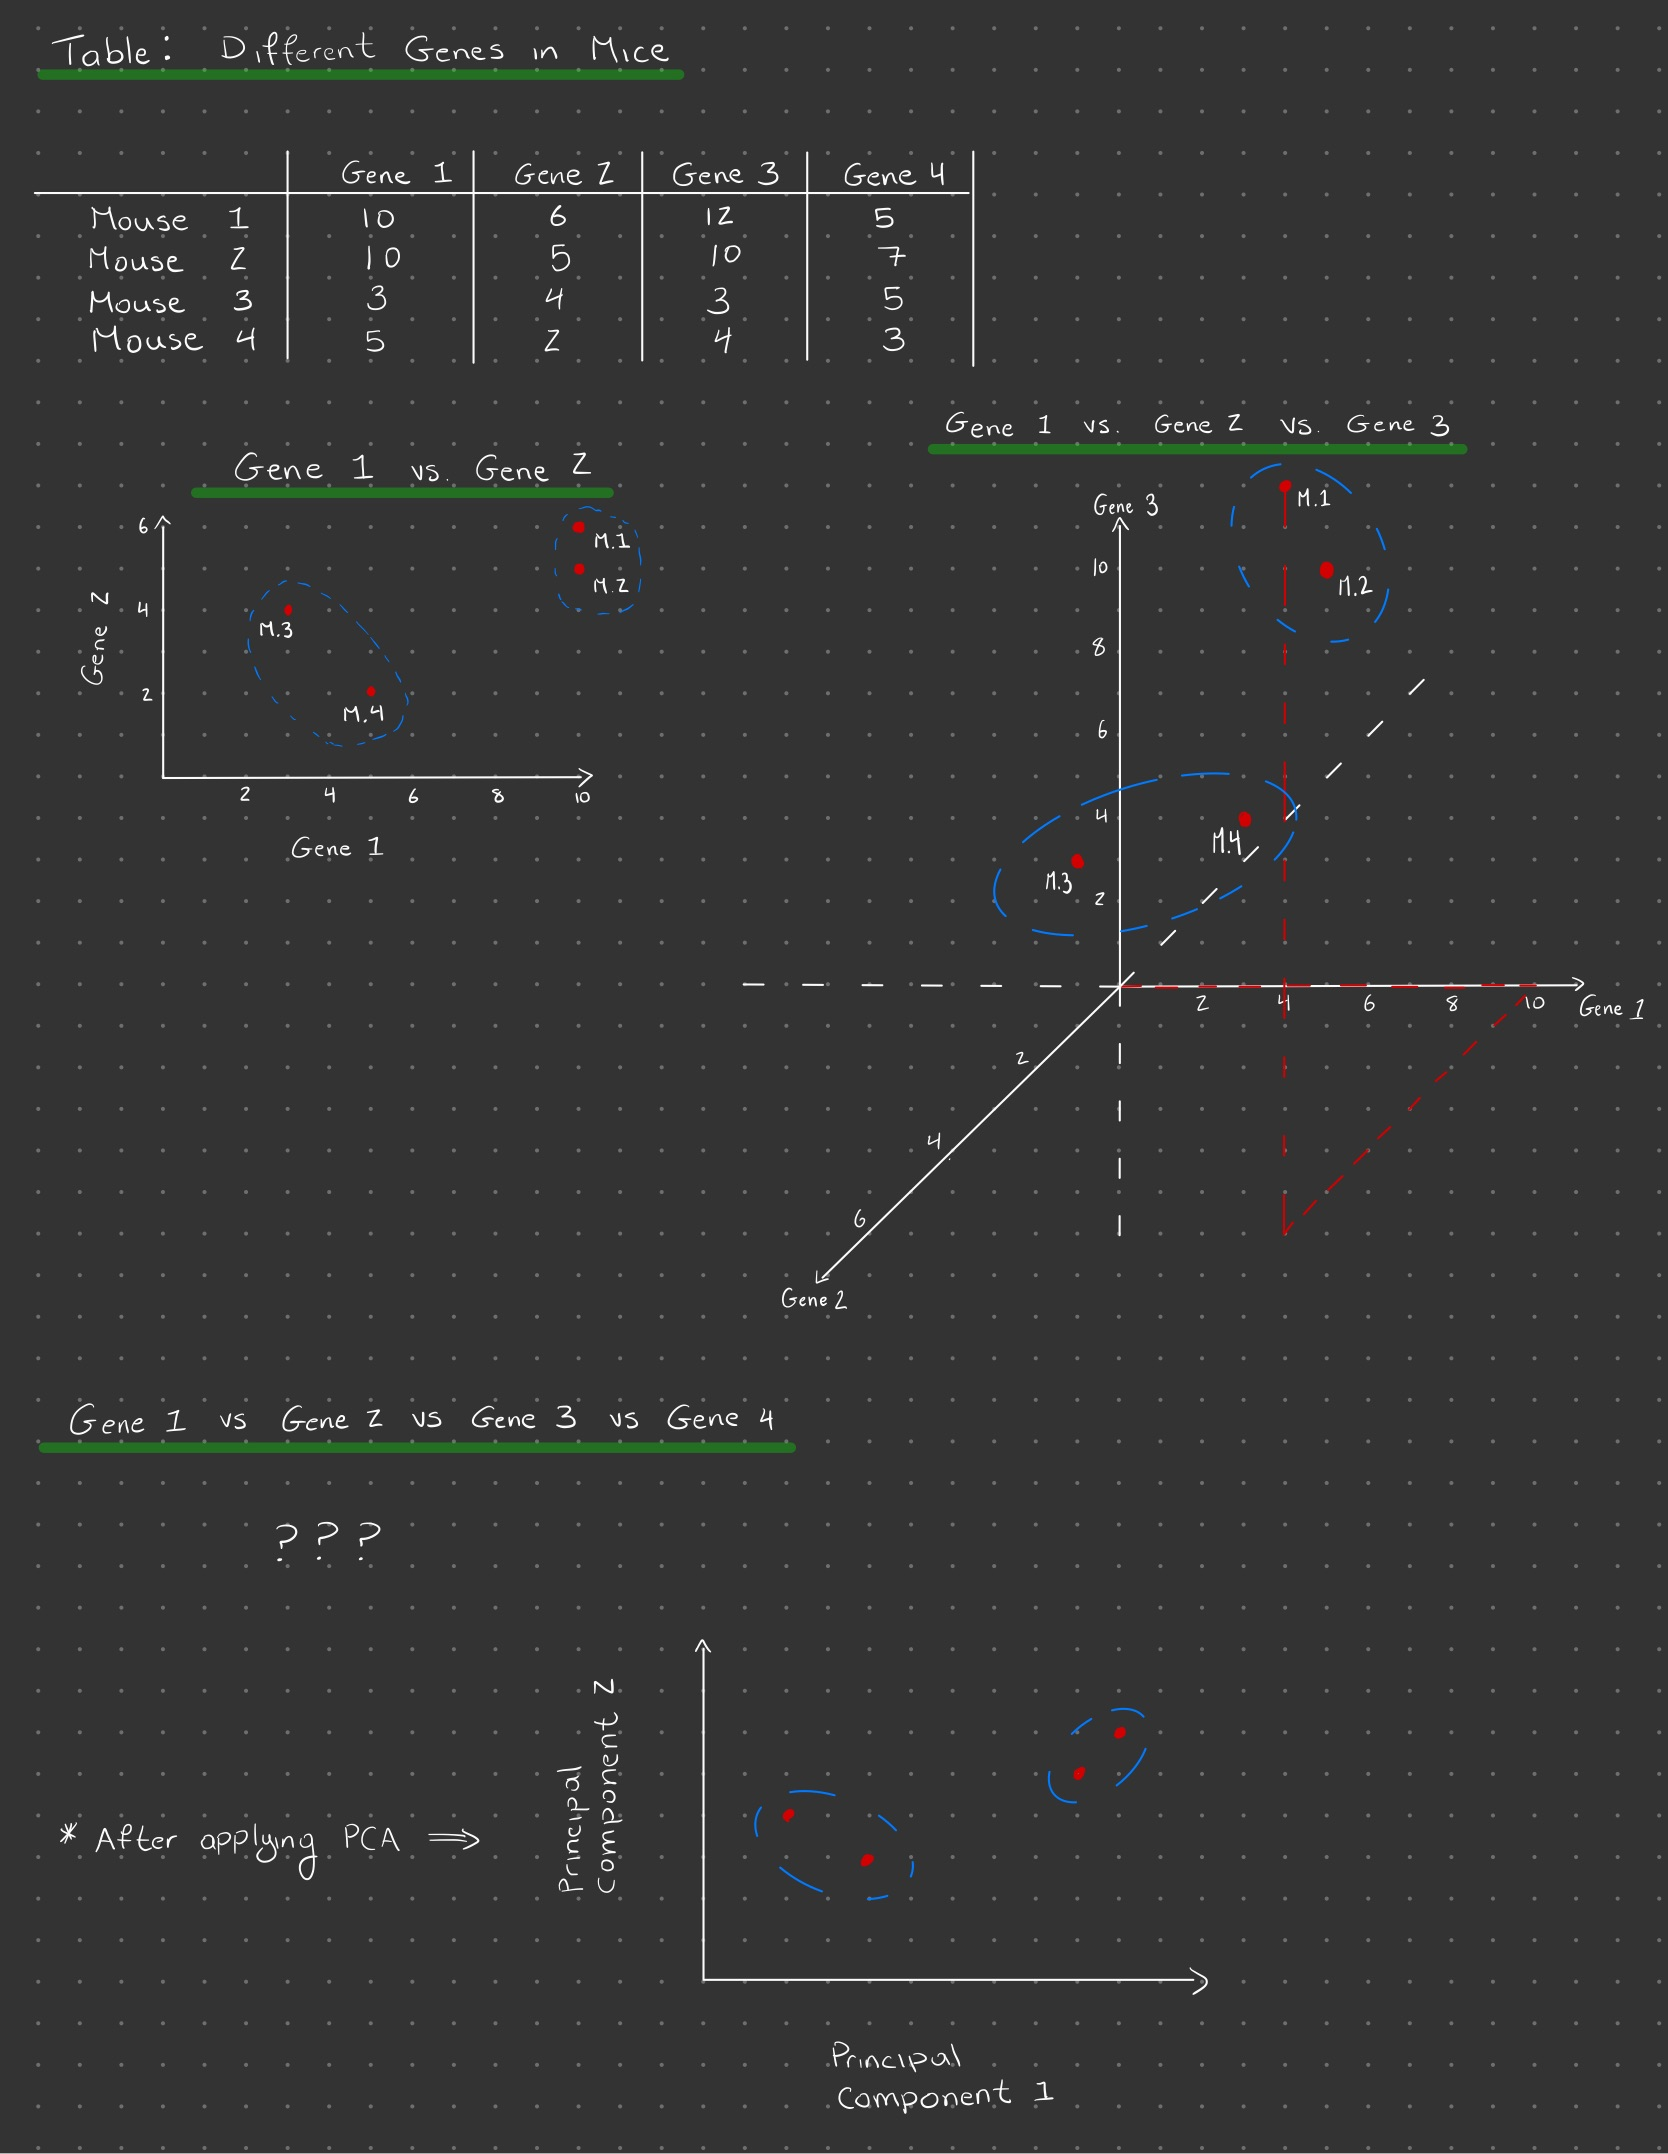

In [2]:
Image(filename= "whatisPCAexample.jpg")

### How does PCA work?

Independent variables with the largest variance in the data will have the most influence on the principle components. Principle component 1 captures the most variation in the data. Principle component 2 captures the second most variation in the data. And so on. PCA will continue this process for the n dimensions that we are working with. In a way PCA orders the dimensions from most important to least important. Keeping in mind that the more variance the data is in a dimension, the more important it is.  The dimensionality reduction can be completed now. Since we have the dimensions in order of significance, we can choose the amount of dimensions we want to select.

Let's continue the example from before to show how it works.

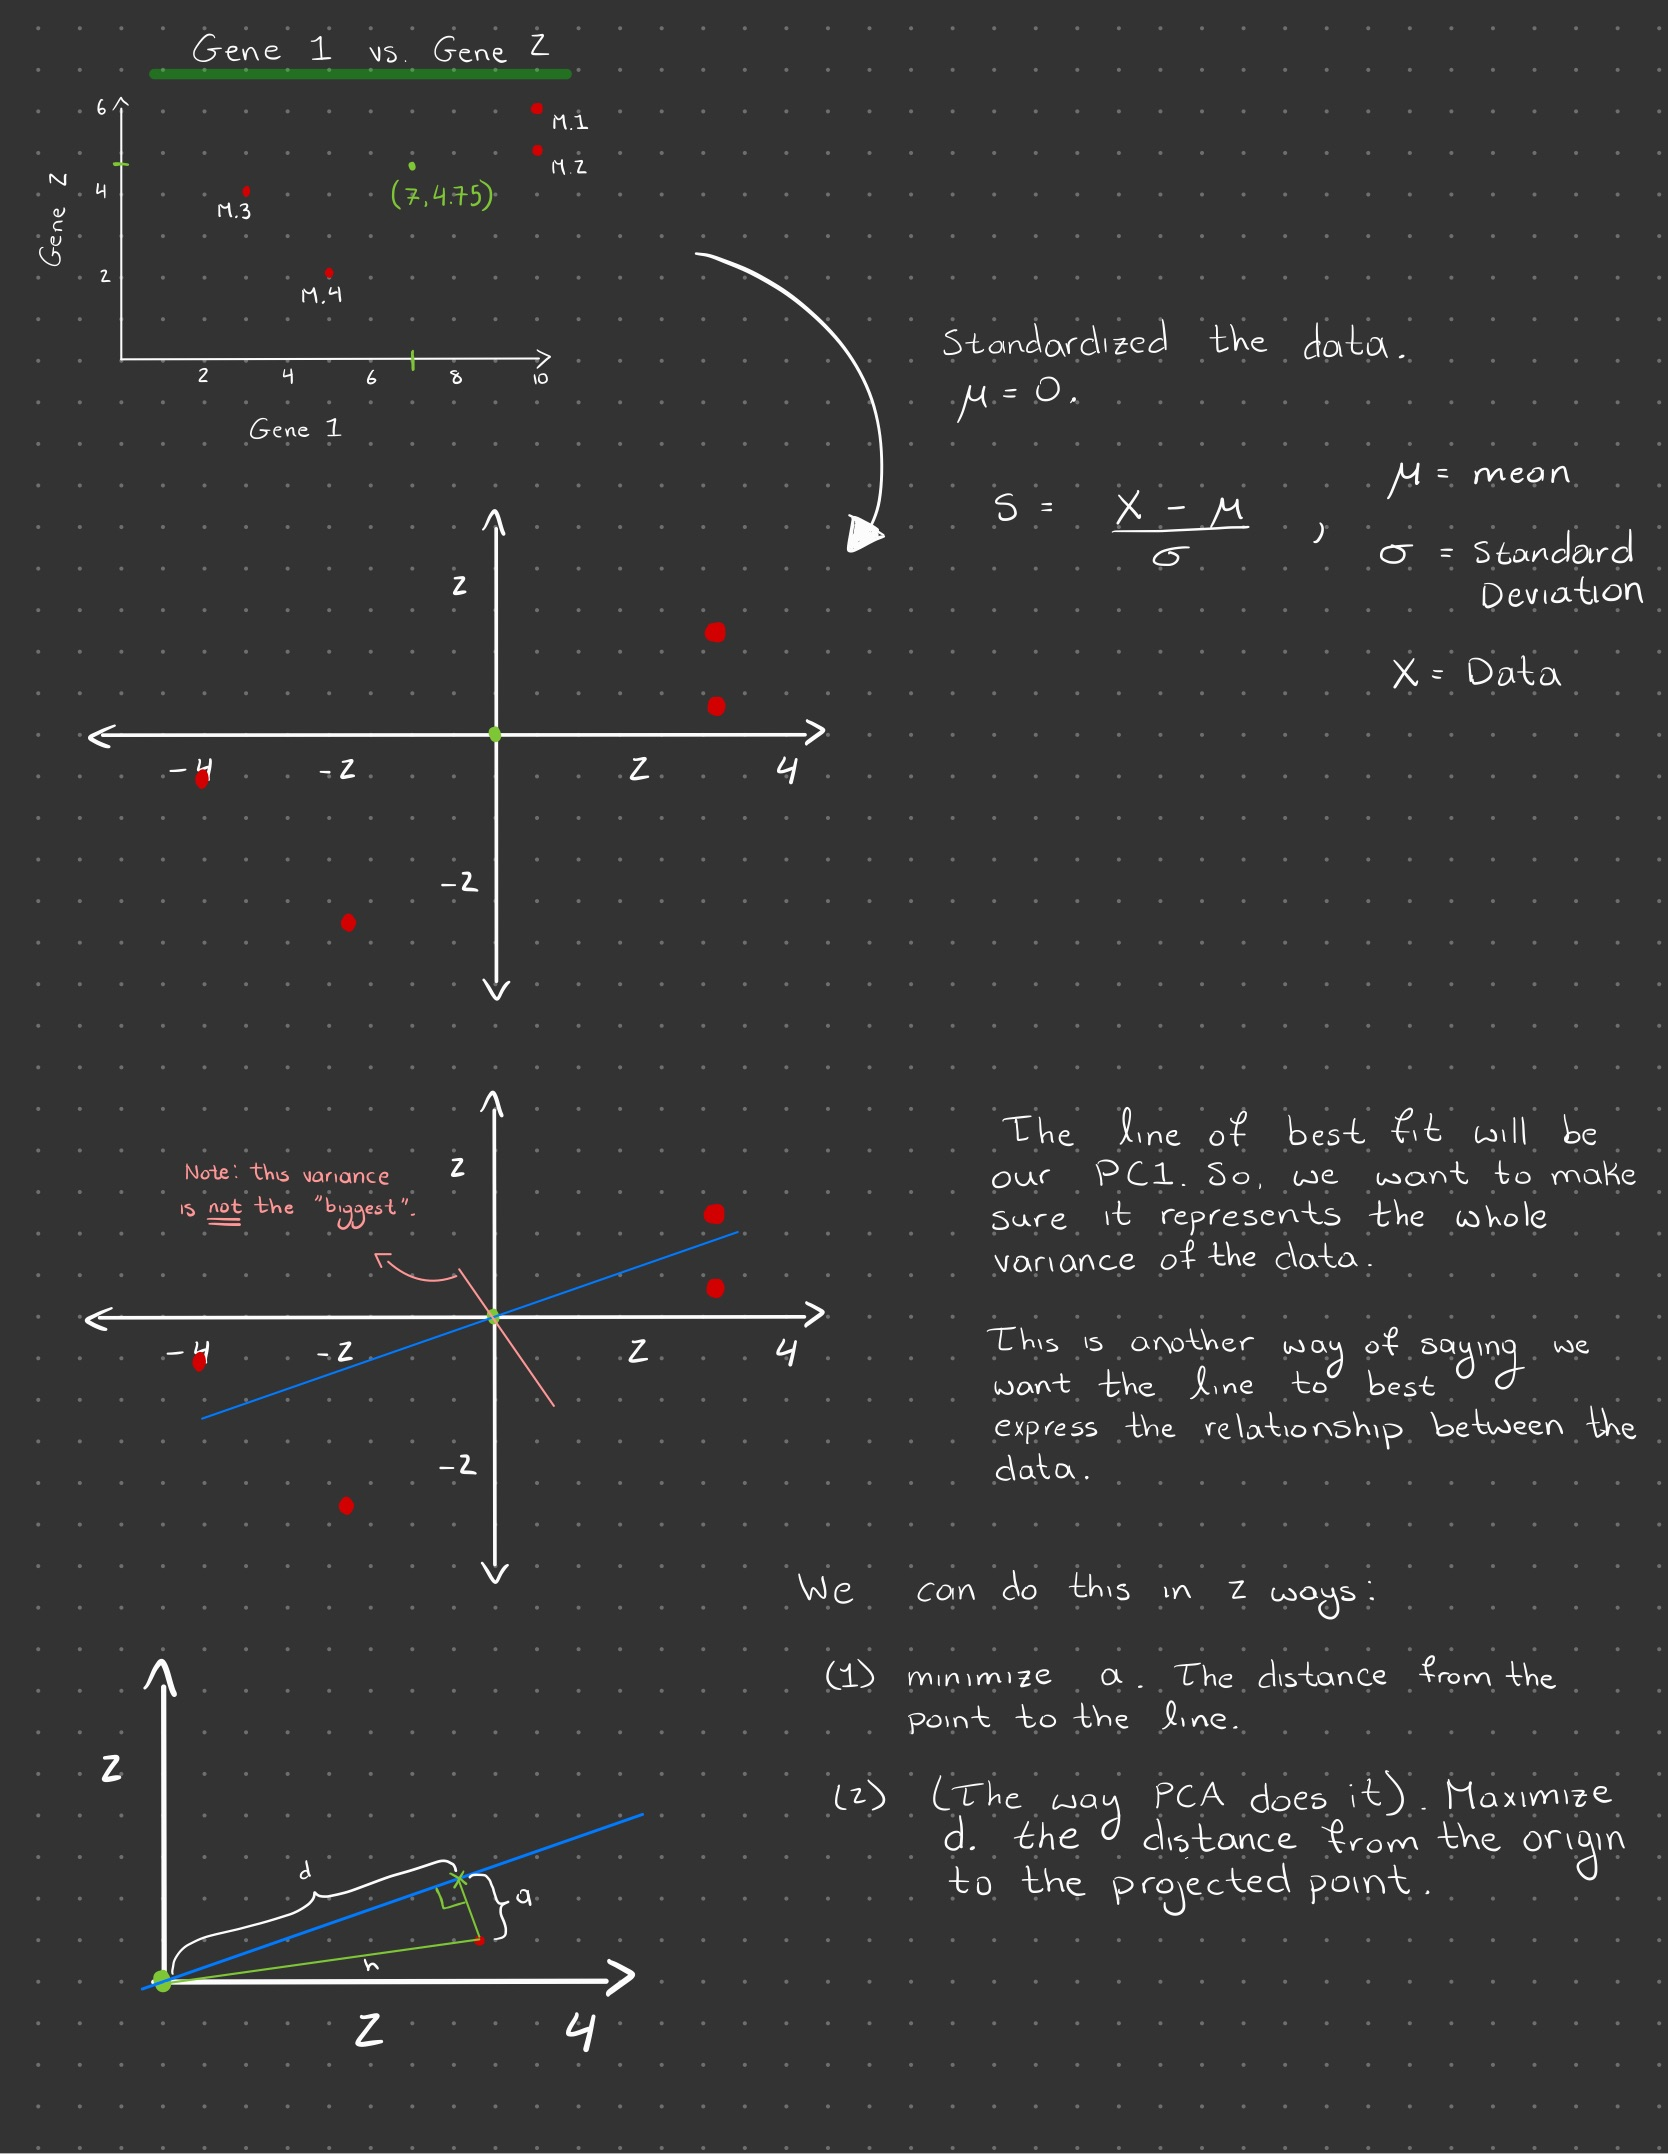

In [3]:
Image(filename= "howPCAworks1.jpg")

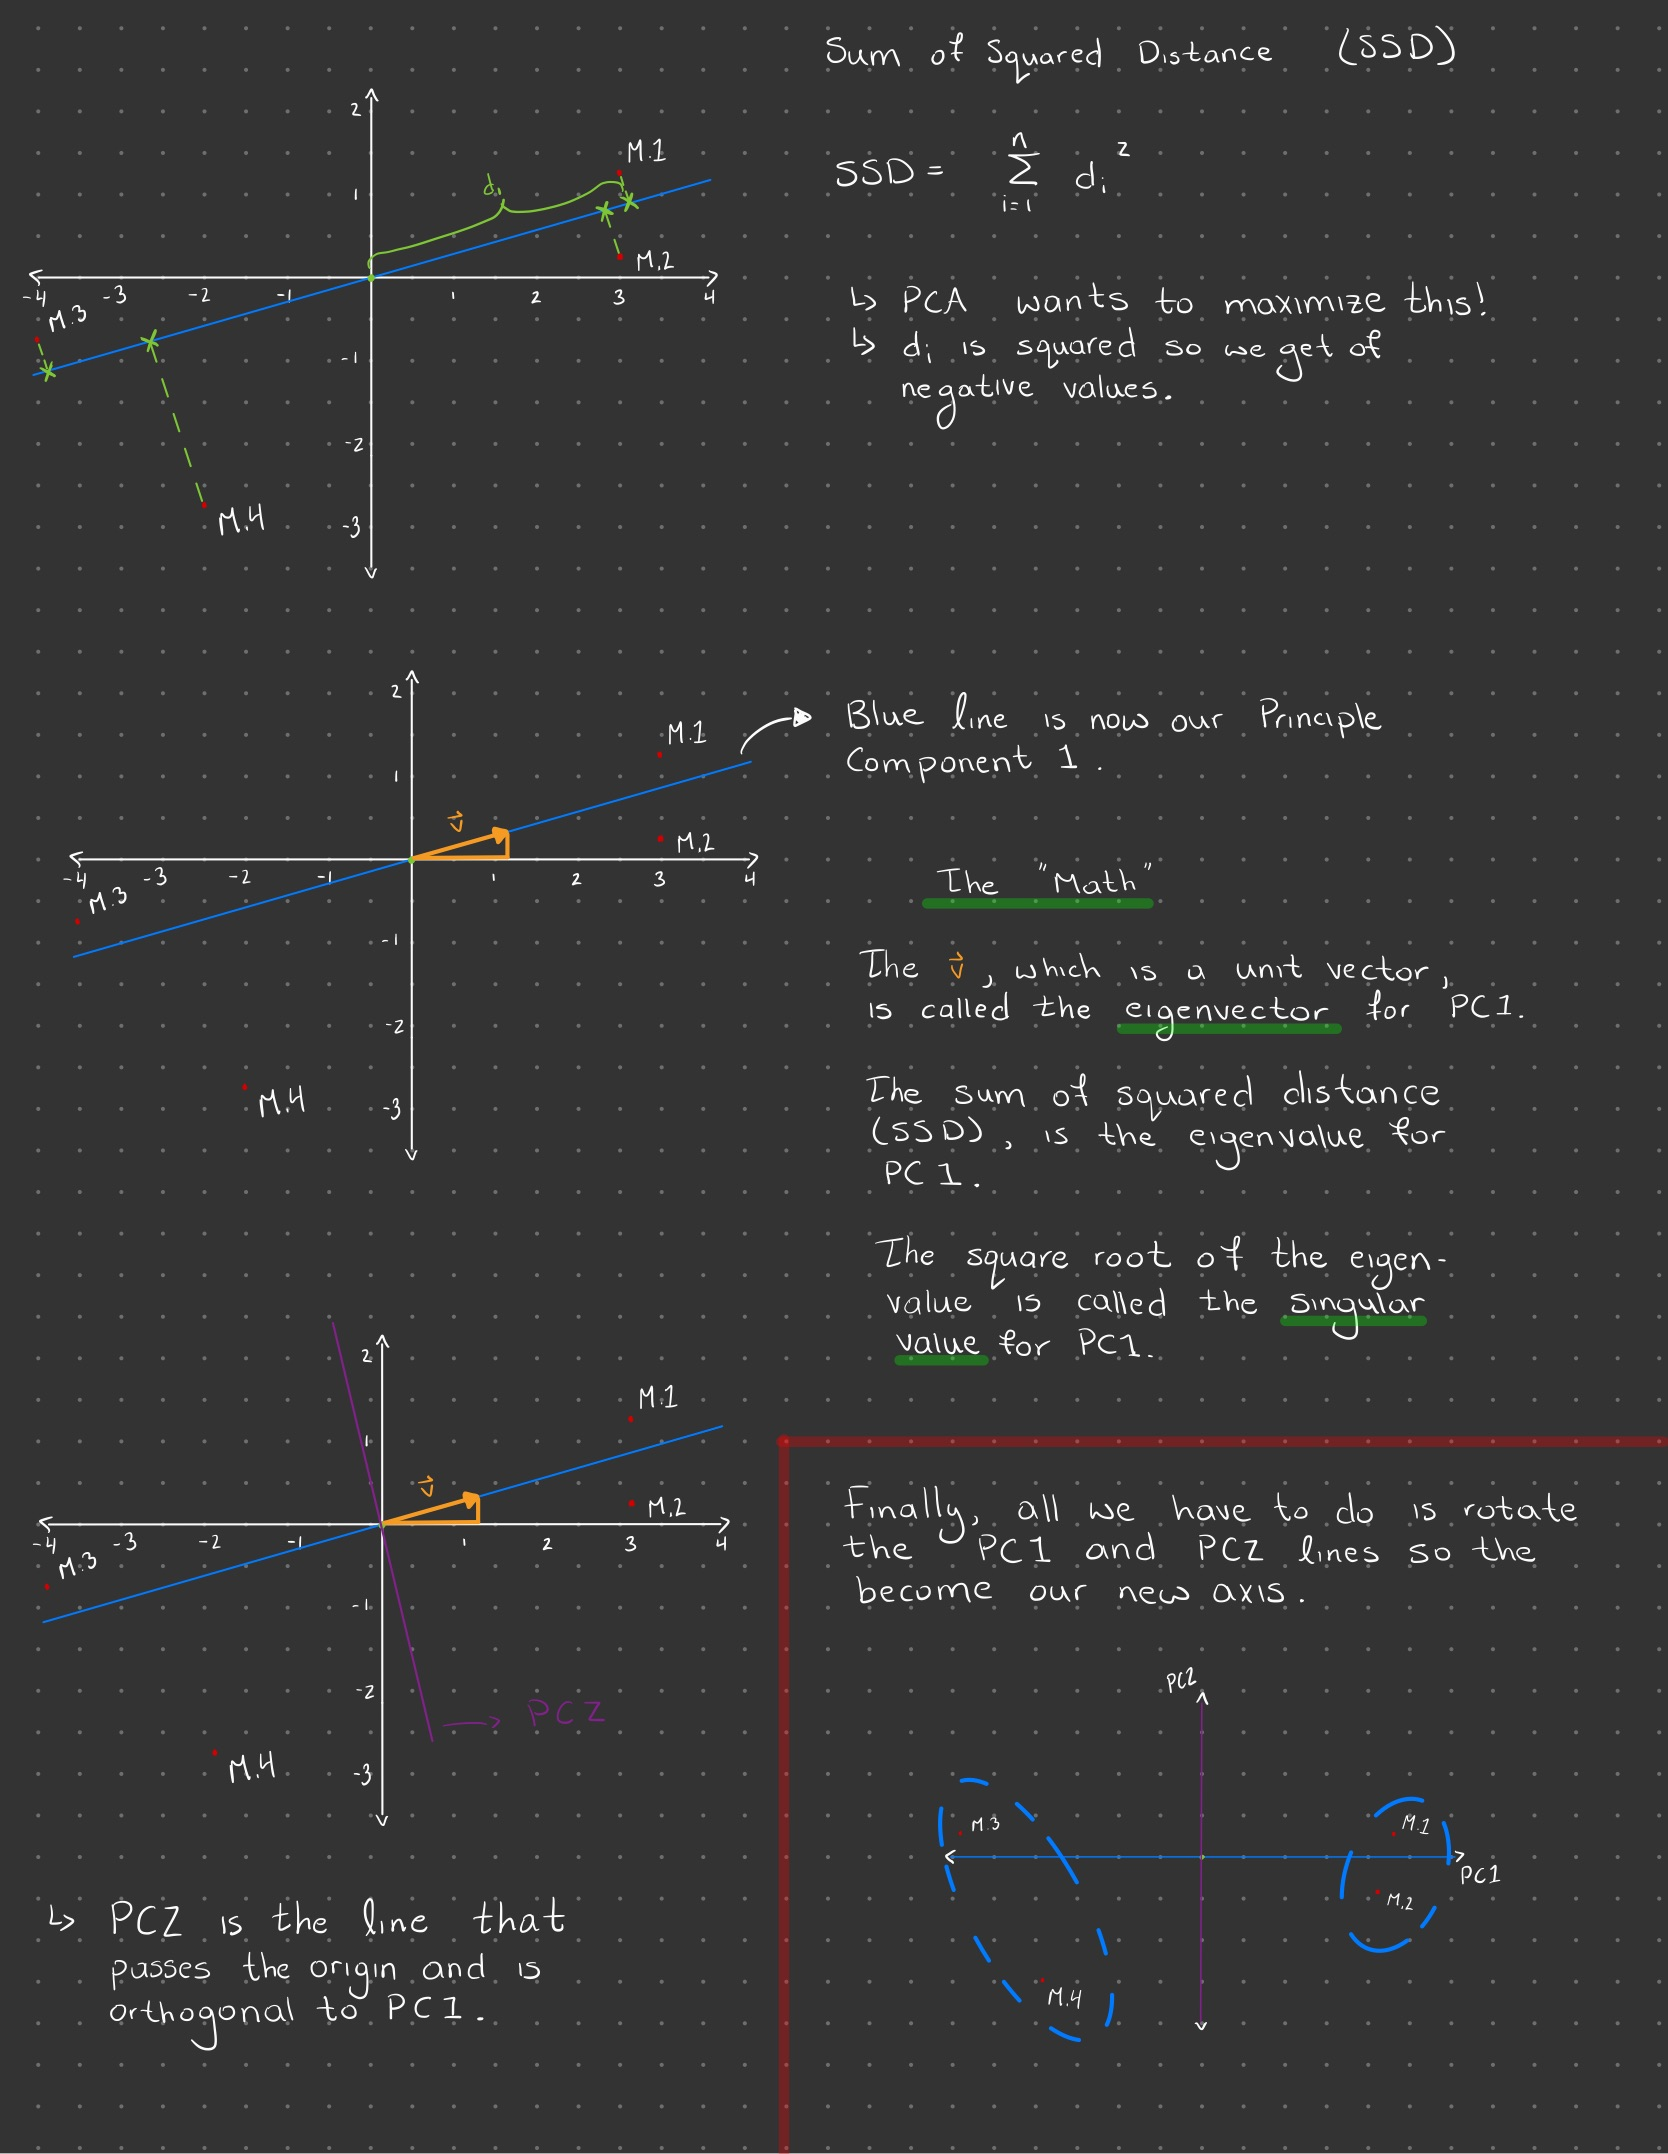

In [4]:
Image(filename= "howPCAworks2.jpg")

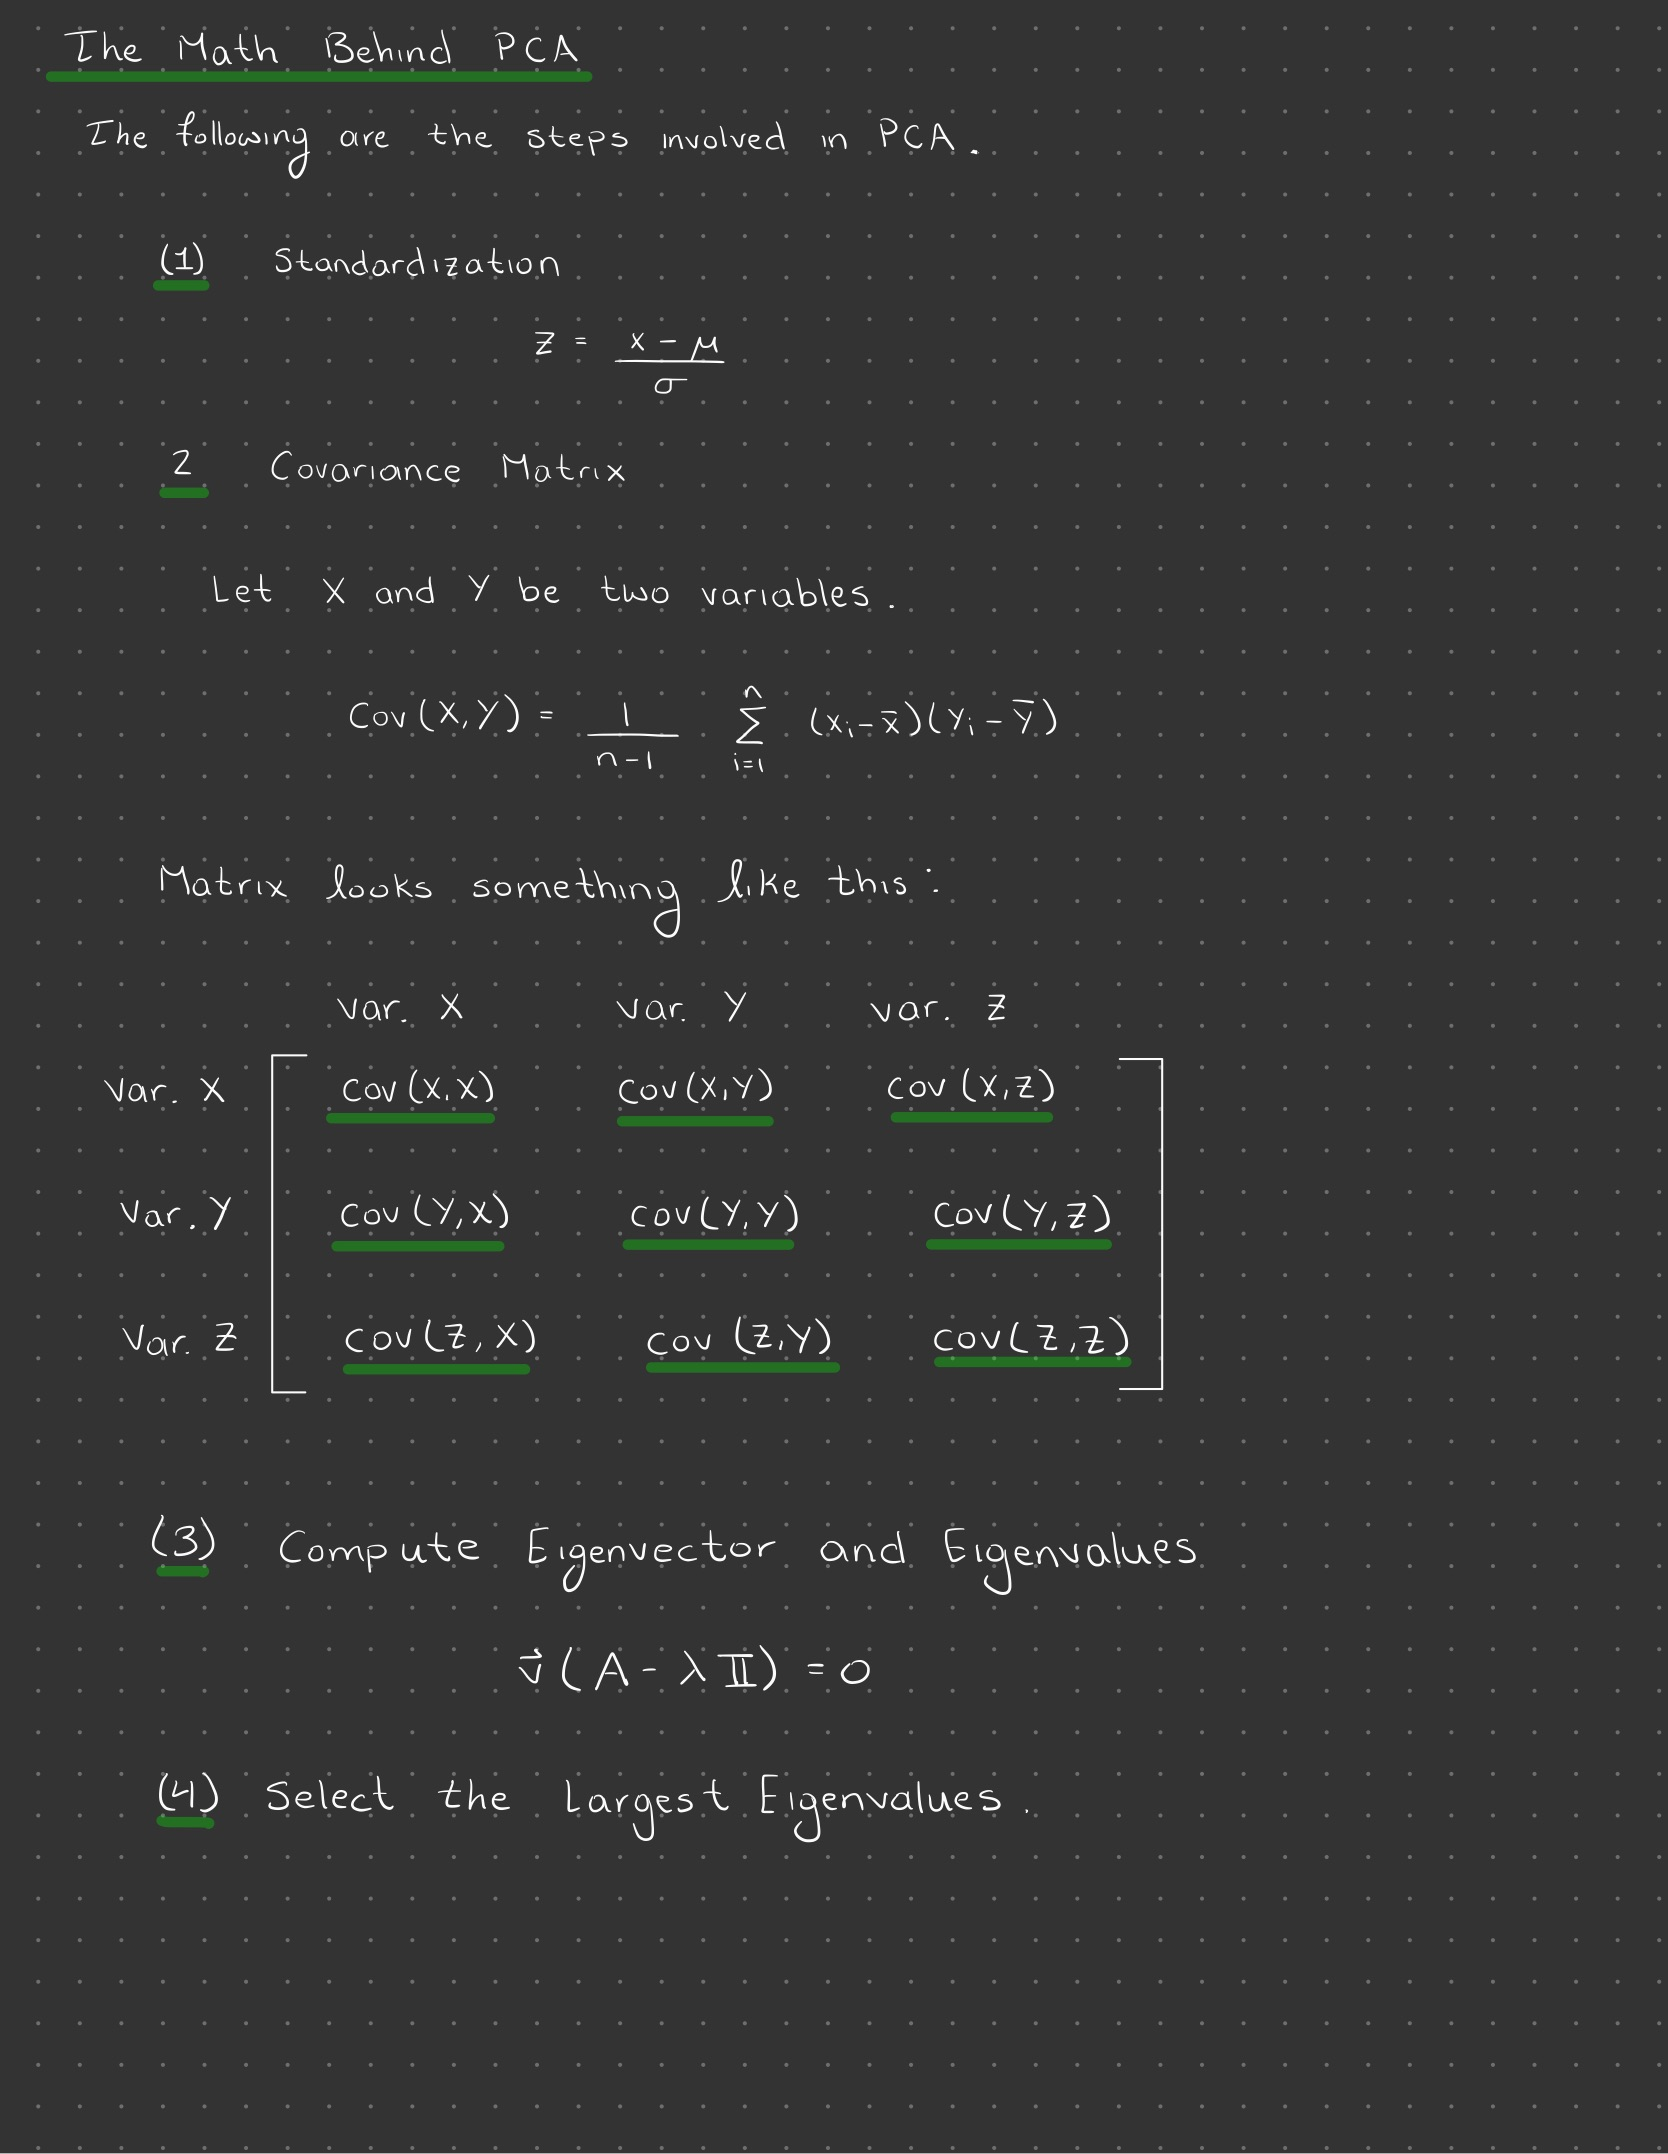

In [5]:
Image(filename= "howPCAworks3.jpg")

### Why do we use PCA?

1. Dimensionality reduction (OBVIOUSLY)

2. Increases performance 

3. Helps us visualize higher dimensions

# -----------------------------------------------------------------

## The Problem 

A hedge fund firm decided to hire us to look over some stocks, and see if we can identify some similarities in behaviour between the stocks. They also asked us to use a machine learning model to try and predict the prices of the stocks. 

# -----------------------------------------------------------------

## Exploring the data

Here we are going to...

1. Join the two databases (tables) we have on the stocks to work with one table. 
2. We will look at how the data looks like and identitfy what we need to fix. 
3. Clean the data. 
4. Split our data.
5. Standardize our data. 

In [6]:
# IMPORTING THE DATA FROM OUR EXCEL FILE 

path = "stocks.xlsx"
quotes = pd.read_excel(path, sheet_name= "Quote")
performances = pd.read_excel(path, sheet_name= "Performance", engine='openpyxl')

In [7]:
# LOOKING AT THE FIRST 5 ROWS OF OUR FIRST TABLE FROM EXCEL

quotes.head(5)

,Exchange Country,Symbol,Company Name,Last Price,Change ($),Change (%),52 Wk High,52 Wk Low,Today's Volume,Average Volume,Sector,Industry
0,CAN,ABZ,Asiabasemetals Inc,$0.18,-0.06,-26.53,$0.64,$0.17,500.0,1.2K,Basic Materials,Metal Mining
1,CAN,ACO.X,ATCO Ltd.,$41.80,0.08,0.19,$42.71,$34.43,137.4K,242.0K,Utilities,Electric Utilities
2,CAN,ACO.Y,ATCO Ltd.,$43.00,0.40,0.94,$46.85,$35.49,1.0K,1.1K,Utilities,Electric Utilities
3,CAN,ACZ,American Core Sectors Dividend Fund,$14.92,0.30,2.05,$15.34,$11.20,1.7K,1.7K,Financial,Miscellaneous Financial Services
4,CAN,ADK,Diagnos Inc,$0.55,0.01,1.85,$0.77,$0.14,3.0K,73.0K,Technology,Software & Programming


In [8]:
# LOOKING AT THE FIRST 5 ROWS OF OUR SECOND TABLE FROM EXCEL

performances.head(5)

,Exchange Country,Symbol,Company Name,3 mo (%),6 mo (%),1 yr (%),3 yr (%),5 yr (%),10 yr (%)
0,CAN,ABZ,Asiabasemetals Inc,0.00,-18.33,-15.52,+36.11,+512.50,-87.95
1,CAN,ACO.X,ATCO Ltd.,+15.41,+7.54,+19.75,+0.82,+6.21,+42.66
2,CAN,ACO.Y,ATCO Ltd.,+15.41,+7.54,+19.75,+2.16,+8.48,+46.18
3,CAN,ACZ,American Core Sectors Dividend Fund,+0.96,+5.87,+27.74,+23.79,+46.05,--
4,CAN,ADK,Diagnos Inc,-10.00,+86.21,+163.41,-22.86,+35.00,-80.36


In [9]:
# 1) HERE WE ARE JOINING BOTH TABLES INTO ONE TABLE

# drop the columns we are not using  
quotes = quotes.drop(columns= [
    "Exchange Country", "Company Name", "Industry"
])

performances = performances.drop(columns= [
    "Exchange Country", "Company Name"
])

# join the two tables using sql 
stocks = sqldf(
    """
    SELECT * 
    FROM quotes AS q 
    LEFT JOIN performances AS p WHERE p.Symbol == q.Symbol;
    """
)

# drop the extra "Symbol" column
stocks = stocks.loc[:,~stocks.columns.duplicated()]

In [10]:
# LOOKING AT THE FIRST 15 ROWS OF OUR RESULTING TABLE

stocks.head(15)

,Symbol,Last Price,Change ($),Change (%),52 Wk High,52 Wk Low,Today's Volume,Average Volume,Sector,3 mo (%),6 mo (%),1 yr (%),3 yr (%),5 yr (%),10 yr (%)
0,ABZ,$0.18,-0.06,-26.53,$0.64,$0.17,500.0,1.2K,Basic Materials,0.00,-18.33,-15.52,+36.11,+512.50,-87.95
1,ACO.X,$41.80,0.08,0.19,$42.71,$34.43,137.4K,242.0K,Utilities,+15.41,+7.54,+19.75,+0.82,+6.21,+42.66
2,ACO.Y,$43.00,0.40,0.94,$46.85,$35.49,1.0K,1.1K,Utilities,+15.41,+7.54,+19.75,+2.16,+8.48,+46.18
3,ACZ,$14.92,0.30,2.05,$15.34,$11.20,1.7K,1.7K,Financial,+0.96,+5.87,+27.74,+23.79,+46.05,--
4,ADK,$0.55,0.01,1.85,$0.77,$0.14,3.0K,73.0K,Technology,-10.00,+86.21,+163.41,-22.86,+35.00,-80.36
5,ADW.A,$10.85,0.02,0.18,$11.68,$7.02,41.5K,69.7K,Consumer/Non-Cyclical,+9.40,+21.73,+68.01,-40.30,+10.32,+248.13
6,ADW.B,$13.30,-0.43,-3.13,$14.68,$7.40,1.5K,1.5K,Consumer/Non-Cyclical,+9.40,+21.73,+68.01,-23.85,+27.44,+309.23
7,AFCC,$1.74,0.04,2.35,$1.75,$1.14,7.9K,24.0K,Financial,+13.73,+20.00,+51.30,-24.44,+25.93,-83.89
8,AHE.H,$0.53,0.00,0.00,$1.28,$0.13,55.0,6.4K,Basic Materials,+47.95,-14.29,+272.41,-92.93,-21.48,-99.08
9,AHR,$0.12,-0.01,-8.00,$0.13,$0.03,73.8K,761.3K,Basic Materials,+84.62,+166.67,+242.86,-7.41,+92.31,-68.92


In [11]:
# WE ARE REPLACING THE "--" VALUES THAT REPRESENT AN "EMPTY" VALUE WITH A MORE LEGIT "EMPTY" VALUE THAT OUR PROGRAM CAN DETECT AS "EMPTY" 

stocks = stocks.replace("--", np.nan)

In [13]:
# 2) LOOKING AT HOW THE DATA LOOKS LIKE AND IDENTIFYING THE ISSUES WITH THE DATA
# TWO PROBLEMS: (1) THE DATA TYPES ARE OBJECTS AND NOT FLOATS. (2) THERE ARE MISSING VALUES.

stocks.head(5)

,Symbol,Last Price,Change ($),Change (%),52 Wk High,52 Wk Low,Today's Volume,Average Volume,Sector,3 mo (%),6 mo (%),1 yr (%),3 yr (%),5 yr (%),10 yr (%)
0,ABZ,$0.18,-0.06,-26.53,$0.64,$0.17,500.0,1.2K,Basic Materials,0.00,-18.33,-15.52,+36.11,+512.50,-87.95
1,ACO.X,$41.80,0.08,0.19,$42.71,$34.43,137.4K,242.0K,Utilities,+15.41,+7.54,+19.75,+0.82,+6.21,+42.66
2,ACO.Y,$43.00,0.40,0.94,$46.85,$35.49,1.0K,1.1K,Utilities,+15.41,+7.54,+19.75,+2.16,+8.48,+46.18
3,ACZ,$14.92,0.30,2.05,$15.34,$11.20,1.7K,1.7K,Financial,+0.96,+5.87,+27.74,+23.79,+46.05,NaN
4,ADK,$0.55,0.01,1.85,$0.77,$0.14,3.0K,73.0K,Technology,-10.00,+86.21,+163.41,-22.86,+35.00,-80.36


In [14]:
# CLOSER LOOK AT EACH COLUMN 

stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          293 non-null    object 
 1   Last Price      293 non-null    object 
 2   Change ($)      293 non-null    float64
 3   Change (%)      293 non-null    float64
 4   52 Wk High      293 non-null    object 
 5   52 Wk Low       293 non-null    object 
 6   Today's Volume  293 non-null    object 
 7   Average Volume  293 non-null    object 
 8   Sector          293 non-null    object 
 9   3 mo (%)        292 non-null    object 
 10  6 mo (%)        288 non-null    object 
 11  1 yr (%)        282 non-null    object 
 12  3 yr (%)        265 non-null    object 
 13  5 yr (%)        238 non-null    object 
 14  10 yr (%)       213 non-null    object 
dtypes: float64(2), object(13)
memory usage: 34.5+ KB


In [15]:
# 3) FIXING THE DATA 
# CHANGE ALL DATA TYPES FROM OBJECTS TO FLOATS. THEN FILLING IN THE EMPTY VALUES. 

# separating each type of column since each type will require a different approach to fixing 
curr = list(stocks.iloc[:, [1, 4, 5]].columns)
vol = list(stocks.iloc[:, [6, 7]])
per = list(stocks.iloc[:, 9:])

# for currency columns, we are removing the "$" and changing the dtype to float
for col in curr:
    stocks[col] = stocks[col].str.replace("$", "")
    stocks[col] = stocks[col].astype("float64")

# for the volumns, we are removing the letters "K" and "M". Then changing dtype to float. Making sure values are multplied by either 1000 or 1000000 to get the full value. 
for col in vol:

    k_ind = stocks[col].str.strip().str[-1] == "K"
    m_ind = stocks[col].str.strip().str[-1] == "M"

    stocks[col] = stocks[col].str.replace("K", "")
    stocks[col] = stocks[col].str.replace("M", "")

    stocks[col] = stocks[col].astype("float64")

    stocks[col][k_ind] = stocks[col][k_ind] * 1000 
    stocks[col][m_ind] = stocks[col][m_ind] * 1000000 

# for percentage columns, we want to change the dtype to floats and then fill in the missing values with the mean of the column where the sectors are the same. 
stocks = stocks.set_index(["Sector"])

for col in per:

    stocks[col] = stocks[col].str.replace('−', '-')
    stocks[col] = stocks[col].str.replace("+", "")
    stocks[col] = stocks[col].str.replace(",", "")
    stocks[col] = stocks[col].astype("float64")

    means = stocks.groupby(["Sector"])[col].mean()
    stocks[col] = stocks[col].fillna(means)

stocks = stocks.reset_index()

<ipython-input-15-5d992ee80ffc>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  stocks[col] = stocks[col].str.replace("$", "")
<ipython-input-15-5d992ee80ffc>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks[col][k_ind] = stocks[col][k_ind] * 1000
<ipython-input-15-5d992ee80ffc>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stocks[col][m_ind] = stocks[col][m_ind] * 1000000
<ipython-input-15-5d992ee80ffc>:34: FutureWarning: The default value of regex w

In [16]:
stocks.head(15)

,Sector,Symbol,Last Price,Change ($),Change (%),52 Wk High,52 Wk Low,Today's Volume,Average Volume,3 mo (%),6 mo (%),1 yr (%),3 yr (%),5 yr (%),10 yr (%)
0,Basic Materials,ABZ,0.18,-0.06,-26.53,0.64,0.17,500.0,1200.0,0.00,-18.33,-15.520000,36.110000,512.50,-87.950000
1,Utilities,ACO.X,41.80,0.08,0.19,42.71,34.43,137400.0,242000.0,15.41,7.54,19.750000,0.820000,6.21,42.660000
2,Utilities,ACO.Y,43.00,0.40,0.94,46.85,35.49,1000.0,1100.0,15.41,7.54,19.750000,2.160000,8.48,46.180000
3,Financial,ACZ,14.92,0.30,2.05,15.34,11.20,1700.0,1700.0,0.96,5.87,27.740000,23.790000,46.05,139.211250
4,Technology,ADK,0.55,0.01,1.85,0.77,0.14,3000.0,73000.0,-10.00,86.21,163.410000,-22.860000,35.00,-80.360000
5,Consumer/Non-Cyclical,ADW.A,10.85,0.02,0.18,11.68,7.02,41500.0,69700.0,9.40,21.73,68.010000,-40.300000,10.32,248.130000
6,Consumer/Non-Cyclical,ADW.B,13.30,-0.43,-3.13,14.68,7.40,1500.0,1500.0,9.40,21.73,68.010000,-23.850000,27.44,309.230000
7,Financial,AFCC,1.74,0.04,2.35,1.75,1.14,7900.0,24000.0,13.73,20.00,51.300000,-24.440000,25.93,-83.890000
8,Basic Materials,AHE.H,0.53,0.00,0.00,1.28,0.13,55.0,6400.0,47.95,-14.29,272.410000,-92.930000,-21.48,-99.080000
9,Basic Materials,AHR,0.12,-0.01,-8.00,0.13,0.03,73800.0,761300.0,84.62,166.67,242.860000,-7.410000,92.31,-68.920000


In [17]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sector          293 non-null    object 
 1   Symbol          293 non-null    object 
 2   Last Price      293 non-null    float64
 3   Change ($)      293 non-null    float64
 4   Change (%)      293 non-null    float64
 5   52 Wk High      293 non-null    float64
 6   52 Wk Low       293 non-null    float64
 7   Today's Volume  293 non-null    float64
 8   Average Volume  293 non-null    float64
 9   3 mo (%)        293 non-null    float64
 10  6 mo (%)        293 non-null    float64
 11  1 yr (%)        293 non-null    float64
 12  3 yr (%)        293 non-null    float64
 13  5 yr (%)        293 non-null    float64
 14  10 yr (%)       293 non-null    float64
dtypes: float64(13), object(2)
memory usage: 34.5+ KB


In [18]:
# 4) SPLITTING OUR DATA 

# splitting the table into the independent variables (dimensions) and our targets
Y = stocks[["Sector", "Symbol", "Last Price"]]
X = stocks.drop(columns= ["Sector", "Symbol", "Last Price"])

# splitting of data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.20, random_state= 0)

# showing the sizes of data 
print(f"Shape of training features: {X_train.shape}")
print(f"Shape of testing features: {X_test.shape}")
print(f"Shape of training targets: {Y_train.shape}")
print(f"Shape of testing targets: {Y_test.shape}")

Shape of training features: (234, 12)
Shape of testing features: (59, 12)
Shape of training targets: (234, 3)
Shape of testing targets: (59, 3)


In [19]:
# LOOKING AT THE FIRST 5 ROWS OF THE TRAINING FEATURES 

X_train.head(5)

,Change ($),Change (%),52 Wk High,52 Wk Low,Today's Volume,Average Volume,3 mo (%),6 mo (%),1 yr (%),3 yr (%),5 yr (%),10 yr (%)
63,0.00,0.00,68.20,41.35,320.0,533.0,32.990000,44.460000,75.170,46.79,137.610000,338.980000
20,0.71,1.75,47.49,31.50,1900000.0,3300000.0,-7.750000,-11.640000,26.260,40.52,40.210000,862.570000
46,0.04,21.88,0.50,0.06,10000.0,12700.0,36.498571,44.690952,639.689,-86.67,200.225385,149.606000
266,-0.25,-8.33,3.40,1.21,174.0,2400.0,81.820000,114.290000,101.340,-29.25,-1.640000,-40.090000
218,0.45,0.55,86.21,46.69,1800000.0,891700.0,7.530000,7.990000,47.790,11.47,62.030000,190.635484


In [20]:
# LOOKING AT THE FIRST 5 ROWS OF THE TARGET VALUES 

Y_train.head(5)

,Sector,Symbol,Last Price
63,Financial,CVG,64.75
20,Services,ATD.B,41.23
46,Healthcare,CHIP.H,0.20
266,Financial,TXT.UN,2.75
218,Services,QSR,82.18


In [21]:
# 5) STANDARDIZING OUR DATA 

# standard function 
scalar = StandardScaler()

# fitting our training set to the function 
scalar.fit(X_train)

# here we are standardizing the data. We only need to do it for the independent variables. 
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

# ------------------------------------

## Applying PCA 

We will first apply PCA to reduce our dimensions to 2. We will observe now with a more concrete example how PCA works. 

Then we will will apply PCA in a more pratical way to continue with our job. The one given to us by the hedge fund firm. 

In [22]:
# this function here is to simply summarize something about PCA for us. We will use it later. Dont worry about it.  

def PCAsummary(PCA):

    samples = PCA.n_samples_
    features = PCA.n_features_
    num_components = PCA.n_components_
    cov = PCA.get_covariance()
    eigenvectors = PCA.components_
    eigenvalues = PCA.explained_variance_
    var_ratio = PCA.explained_variance_ratio_

    print(f"PCA1 number of samples in the training data: \n\n{samples}\n")
    print(f"PCA1 number of features in the training data: \n\n{features}\n")
    print(f"PCA1 number of features/dimensions we reduced to: \n\n{num_components}\n")
    print(f"PCA1 covariance matrix: \n\n{cov}\n")
    print(f"PCA1 eigenvectors: \n\n{eigenvectors}\n")
    print(f"PCA1 eigenvalues: \n\n{eigenvalues}\n")
    print(f"PCA1 percentage of variance explained by each component: \n\n{var_ratio}\n")

In [23]:
# WE ARE APPLYING PCA TO REDUCE THE DIMENSIONS TO 2 DIMENSIONS. 

# copying the data so we dont change anything with the originals 
x = copy.deepcopy(X_train)
y = copy.deepcopy(Y_train)

# creating the PCA and setting the dimension we want to reduce to, to 2
pca1 = PCA(n_components= 2)

# transforming the data 
pca1.fit(X_train)
x = pca1.transform(X_train)

principlecomponentsdf = pd.DataFrame(data= x, columns= ["PC 1", "PC 2"])

finalDf = pd.concat([principlecomponentsdf, y], axis= 1)
finalDf = finalDf.drop(columns= ["Sector", "Last Price"])
finalDf.head(5)

,PC 1,PC 2,Symbol
0,0.620361,-0.330693,ABZ
1,1.843305,1.035662,ACO.X
2,-0.690588,0.756620,ACO.Y
3,-0.983081,-0.387460,ACZ
4,1.616941,0.241523,ADK


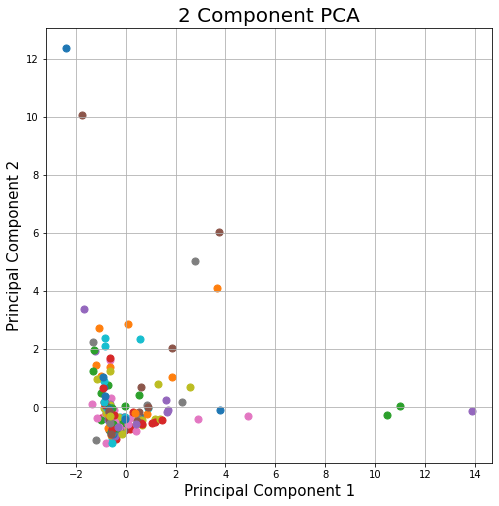

In [24]:
# PLOTTING THE PCA GRAPH 

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)

targets = list(finalDf["Symbol"].unique())

for target in targets:
    indicesToKeep = finalDf['Symbol'] == target
    ax.scatter(
        finalDf.loc[indicesToKeep, 'PC 1'], 
        finalDf.loc[indicesToKeep, 'PC 2'], 
        s= 50
    )

ax.grid()

In [25]:
# CALLING THE FUNCTION FROM EARLIER (THE ONE I TOLD YOU NOT TO WORRY ABOUT) TO SEE MORE DETAILS ABOUT THE PCA THAT WE JUST APPLIED.

PCAsummary(pca1)

PCA1 number of samples in the training data: 

234

PCA1 number of features in the training data: 

12

PCA1 number of features/dimensions we reduced to: 

2

PCA1 covariance matrix: 

[[ 1.32842054  0.01948626  0.66400863  0.66342081  0.19575649  0.22338634 -0.13115052 -0.0685123  -0.07848099 -0.066499   -0.0755125   0.12637147]
 [ 0.01948626  0.79761353  0.00444672  0.00321415  0.14871982  0.1371786   0.13543682  0.16859489  0.17514119  0.09499057  0.02231351  0.02262456]
 [ 0.66400863  0.00444672  1.40210797  0.7027049   0.18306349  0.2142481  -0.1612785  -0.10033049 -0.11197322 -0.08610031 -0.08371104  0.130237  ]
 [ 0.66342081  0.00321415  0.7027049   1.40128248  0.1811134   0.21242578 -0.16288412 -0.10238134 -0.11409968 -0.08724045 -0.0839459   0.12988717]
 [ 0.19575649  0.14871982  0.18306349  0.1811134   0.96747531  0.259045    0.16222159  0.227135    0.23401066  0.12055424  0.01239035  0.06653378]
 [ 0.22338634  0.1371786   0.2142481   0.21242578  0.259045    0.95136026  0.138

What the %$#&@^ is going on? 

Let us break this down step by step... 

- 234 samples is the number of stocks we are observing. We already knew that from splitting the data earlier. We know this. 

- 12 is the number of features (dimensions) that we are starting with. The features are the columns in the table.

- 2 is the number of dimensions we are reduced to after applying PCA. 

- The covariance matrix shows the covariance between every pair of features. This is the matrix that will be used to calculate the eigenvectors and eigenvalues. 

- The eigenvectors...are just that. They are eigenvectors that we have been working with since high school. The difference is, instead of the vector being in 2D or 3D i.e (x,y) or (x,y,z), the eignevectors in our case are 12D. So, (x,y,z,...). They are also in order. So principle component 1 is the axis lying on the first eigenvector. The principle component lies on the second eigenvector. 

- The eigenvalues are in a descending order. The eigenvalues, in a way, represent the variance of each principle component. Since the eigenvalue is the distance from the origin to the projected point on the line of best fit, it is reasonable to conclude that the larger the variance, the larger the combine sum of all the distances. We already know that the first principle component captures the most variance in the data, the second captures the second most variance and so on. So it makes sense the eigenvalues are in a descending order. 

- The explained variance is very important. It gives us the percentage of information covered for each principle component. So, for the first principle component, it covers 24.55% of information. The second principle component covers 17.45%. Again, we see that the variance descreases. Together, both principle components cover 42% of our data. This is bad. We know that a con of using PCA is loss of information but we do not want to lose too much information. We should aim for a min of 85% of variance. 

We only did 2 principle components for the sake of explaining how it works better. Now we will apply PCA with 80% variance. 

In [26]:
# APPLYNG PCA TO OUR ACTUAL DATA NOW. WE WANT TO MAINTAIN AT LEAST 80% OF VARIANCE.

#pca function. 80% variances
pca = PCA(0.80)

# fitting our data
pca.fit(X_train)

# transforming the data
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

principlecomponentsdf = pd.DataFrame(data= X_train, columns= ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6"])

finalDf = pd.concat([principlecomponentsdf, Y_train], axis= 1)
finalDf = finalDf.drop(columns= ["Sector", "Last Price"])
finalDf.head(5)


,PC 1,PC 2,PC 3,PC 4,PC 5,PC 6,Symbol
0,0.620361,-0.330693,-0.589782,0.246611,-0.084928,0.589314,ABZ
1,1.843305,1.035662,1.696907,1.153448,0.777709,2.152944,ACO.X
2,-0.690588,0.756620,-0.796566,-0.595536,2.638335,-0.327992,ACO.Y
3,-0.983081,-0.387460,0.074179,-0.755746,-1.464989,0.230705,ACZ
4,1.616941,0.241523,0.782315,0.115941,0.082274,0.179827,ADK


In [27]:
# HERE WE ARE PLOTTING A SCATTER PLOT MATRIX TO SHOW THE HOW PCA WAS APPLIED.    

Y_train["Symbol & Sector"] = Y_train["Symbol"].str.cat(Y_train["Sector"], sep= ", ")

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    X_train,
    labels= labels,
    dimensions= range(6),
    color= Y_train["Symbol & Sector"]
)

fig.update_traces(diagonal_visible=True)
fig.update_layout(
    width= 1500,
    height= 1500,
    paper_bgcolor="LightSteelBlue",
)

fig.show()

<ipython-input-27-ff45d2261467>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_train["Symbol & Sector"] = Y_train["Symbol"].str.cat(Y_train["Sector"], sep= ", ")


In [28]:
# SUMMARY OF THE PCA WE JUST APPLIED TO THE ORIGINAL DATA

PCAsummary(pca)

PCA1 number of samples in the training data: 

234

PCA1 number of features in the training data: 

12

PCA1 number of features/dimensions we reduced to: 

6

PCA1 covariance matrix: 

[[ 1.11614069  0.08416066  0.80283244  0.79932608  0.10717804  0.1346091  -0.09844072 -0.01288917 -0.05381001 -0.03310299 -0.05168584  0.13620415]
 [ 0.08416066  0.98176053  0.00631559  0.00337872  0.05936087  0.02935308  0.09573723  0.35602044  0.11973088  0.00106432  0.08683175  0.0055635 ]
 [ 0.80283244  0.00631559  1.20227136  0.84909293  0.0922803   0.12552104 -0.11347462 -0.05818396 -0.07927323 -0.04727123 -0.07825086  0.13394496]
 [ 0.79932608  0.00337872  0.84909293  1.19578243  0.10013014  0.13376239 -0.1206789  -0.06580331 -0.0852885  -0.05323409 -0.08123627  0.12811992]
 [ 0.10717804  0.05936087  0.0922803   0.10013014  1.08869086  0.73793562 -0.00253291  0.06141166  0.17507253  0.02499897 -0.05181704  0.00327834]
 [ 0.1346091   0.02935308  0.12552104  0.13376239  0.73793562  1.0907544  -0.032

Remarks: 

- Number of samples and the number of features are still the same. We are using the same data. 

- To maintain 80% of the variance in the data, we will be working with 6 principle components. Thus, reducing the dimension size from 12 to 6.

- The eigenvectors are generated from the covariance matrix. And as expected, the eigenvalues are in descending order. Pay attention to the fact that the first two eigenvectors are the same from earlier. It is because we used the same data.

- There are 6 eigenvectors and eigenvalues because we are working with 6 principle components.

- The total variance covered is 24.55% + 17.45% + 13.83% + 11.35% + 7.96 + 7.45% = 82.59%. Which is expected since we "told" our PCA function to calculate the principle components so that AT LEAST 80% of information is kept. 

- And of course, the variance is in descending order since principle component 1 captures the most variance in the data, and so on. 


what can we infer just by looking at the scatter plot matrix? 

- It is clear to us that majority of the stocks behave in a similar manner. We can see a cluster of dots on our scatter plot that are located in the same area. 

- Sectors like Financial, Healthcare, Basic Materials, and Technology are not as similar as to themselves compared to other sectors. Other sectors remain clustered in one area regardless of the principle components you observe the PCA from. 

- #INTL in the Technology sector, #THRM in the Healthcare sector, #PTF in the Financial sector, and a few more, we can see do not fall into that cluster with the rest of the stocks. That means they might behave different than the rest of the market. Or at the least, majority of the market. 

# -----------------------------------------------

## Small intro to machine learning 

Machine learning is when large amounts of data is used to train a machine, so it is able to make more educated prediction. This is a very simple definition to machine learning. 

An example of machine learning is our own emails. How does our email know that an email we received is spam or not so it can automatically toss it into our spam folder? 

# -----------------------------------------------

## Training and testing our machine learning model

We are going to use a linear regression as our machine learning model. 

We will train the model using the data after applying PCA to it and show the results. Then, we will then train the model using the original data, before applying PCA to it and show the results. For each time, we will show the errors between the actual value and the predicted value from the model. And show the time it took to train the model. 

The goal is not exactly to have a more accurate model (less errors) but to show that our model trains faster using PCA. 

In [29]:
# WE ARE SETTIN OUR TARGET VARIABLE/DEPENDENT VARIABLE AS THE PRICE OF THE STOCK. THAT IS WHAT WE TRYING TO PREDICT.

Y_train = Y_train["Last Price"]
Y_test = Y_test["Last Price"]
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

In [32]:
# CREATING OUR MODEL AND TRAINING IT. THEN WE ARE USING IT TO PREDECT THE PRICES OF OUR TESTING FEATURES. 

# training and testing the linear regression 
model = LinearRegression()
t = time.time()
model.fit(X_train, Y_train)
elapsed = time.time() - t
print("\n\n")
print("Time it took to train the model: ", elapsed)
Y_pred = model.predict(X_test)

# showing the results in a table 
results = pd.DataFrame({"Actual": Y_test, "Predicted": Y_pred})
print("\n\n")
print(results)
print("\n\n")

# calculating the errors 
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))




Time it took to train the model:  0.005925893783569336



    Actual   Predicted
0    12.90   10.205789
1    25.19   24.531900
2     0.24    1.312870
3     0.08    3.599673
4     0.50    3.162966
5     0.28    3.159094
6    57.00   84.127647
7    22.95   14.878748
8     1.89    4.769093
9     0.56    1.472464
10   24.10   16.936713
11   23.54   16.683942
12    0.77    0.800861
13    0.75    1.313196
14    0.29    1.053744
15   16.71   -0.887163
16    5.90    6.296239
17    0.16    4.404082
18   25.08   25.865666
19    0.13   -1.316990
20   10.35   10.750078
21   45.19   45.756194
22   18.10   14.331863
23   18.89   11.800692
24    0.25    1.555547
25    4.68    5.350321
26    0.53    2.540317
27    0.10    1.296008
28   25.72   22.792659
29   18.00   16.504361
30   20.63   19.341867
31    0.27   -1.066610
32    0.08    1.285070
33   10.85   10.214955
34    1.15    1.893860
35    7.01    4.759887
36    0.04   -0.395795
37    0.76   -0.105847
38    1.51    1.909561
39    0.17    0.123

In [33]:
# TRAINING AND TESTING THE MODEL ON THE ORIGINAL DATA. BEFORE PCA. 

y = stocks["Last Price"]
x = stocks.drop(columns= ["Sector", "Symbol", "Last Price"])

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.20, random_state= 0)

mdl = LinearRegression()
t = time.time()
mdl.fit(x_train, y_train)
elapsed = time.time() - t
y_pred = mdl.predict(x_test)

print("\n\n")
print("Time it took to train the model: ", elapsed)
print("\n\n")

results = pd.DataFrame({"Actual": y_test, "Predicted": y_pred})
print(results)
print("\n\n")
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))




Time it took to train the model:  0.006119251251220703



     Actual   Predicted
226   12.90   12.433809
285   25.19   25.174318
209    0.24   -0.651636
171    0.08   -0.042990
118    0.50   -0.073919
275    0.28    0.046326
73    57.00   53.552816
157   22.95   22.475308
129    1.89    1.708814
45     0.56    0.027586
135   24.10   24.335357
15    23.54   23.214844
152    0.77    1.120643
217    0.75    0.387468
92     0.29   -0.106283
12    16.71   17.391612
246    5.90    4.995555
22     0.16    0.328909
166   25.08   24.927797
268    0.13   -0.222539
227   10.35    9.996097
288   45.19   52.092815
194   18.10   17.457689
258   18.89   19.094700
241    0.25   -0.387193
274    4.68    4.358442
8      0.53    0.760881
168    0.10   -0.549472
284   25.72   25.845933
156   18.00   17.855828
224   20.63   23.175346
182    0.27   -0.190419
175    0.08   -0.203667
5     10.85   10.720400
205    1.15    0.596728
103    7.01    6.688751
212    0.04    0.630883
249    0.76    0.189326
219

# ------------------------------------------------------------------

## Conclusion + Q&A time 

Key points to know about PCA: 

- It reduces dimensionality (duh)
- There is a trade off between speed and accuracy 




Thank you :) 

Questions? 